In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import random

import bt_mle_utils as mle
from simulation_utils import *

## Barbell

In [2]:
E = random_edge(5,5,10)
np.sum(E)

10.0

In [3]:
A = get_barbell_adj(n1 = 3, n2 = 5, bridge = 1)
A

array([[0., 1., 1., 0., 0., 0., 0., 0.],
       [1., 0., 1., 0., 0., 0., 0., 0.],
       [1., 1., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 1., 1., 1., 1.],
       [0., 0., 0., 1., 0., 1., 1., 1.],
       [0., 0., 0., 1., 1., 0., 1., 1.],
       [0., 0., 0., 1., 1., 1., 0., 1.],
       [0., 0., 0., 1., 1., 1., 1., 0.]])

In [4]:
n1, n2 = 50, 50
bridge_list = np.arange(50) * 50
lam2_list = []
min_n_ij_list = []
B = 10
for bridge in bridge_list:
    lam, n_ij = 0, 0
    for b in range(B):
        A = get_barbell_adj(n1 = n1, n2 = n2, bridge = bridge)
        lam2, lamn = lambda2_A(A)
        lam += lam2 / B
        n_ij += min_n_ij(A) / B
    lam2_list.append(lam)
    min_n_ij_list.append(n_ij)
lam2_list = np.array(lam2_list)
min_n_ij_list = np.array(min_n_ij_list)

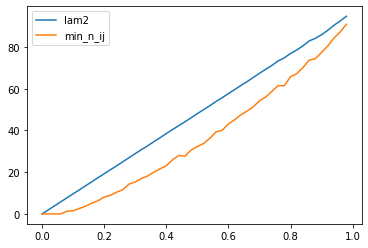

In [5]:
plt.plot(bridge_list / (n1 * n2), lam2_list)
plt.plot(bridge_list / (n1 * n2), min_n_ij_list)
plt.legend(['lam2','min_n_ij'])

In [93]:
import time

In [137]:
ns_list = np.array([50, 75, 100, 200, 300, 400, 600, 800, 1000])

m = len(ns_list)
B = 100

lam2_list = np.zeros(m)
min_n_ij_list = np.zeros(m)
n_max_list = np.zeros(m)
n_min_list = np.zeros(m)

bound_yan_list = np.zeros(m)
bound_shah_list = np.zeros(m)
bound_our_list = np.zeros(m)
ratio_list = np.zeros(m)


bound_yan_mat = np.zeros((m,B))
bound_shah_mat = np.zeros((m,B))
bound_our_mat = np.zeros((m,B))
ratio_mat = np.zeros((m,B))

np.random.seed(0)

for ix, ns in enumerate(ns_list):
    st = time.time()
    n1, n2 = ns, ns
    n = n1 + n2

    # delta = np.log(n) / n
    k = 10
    t = 0.7
    kappa = np.log(t / (1 - t))
    delta = 1
    beta = get_beta_with_gap(n, delta)
    beta *= kappa / (np.max(beta) - np.min(beta))
    total = 10

    p_bridge = 3 * np.log(n1) / n1
    bridge = int(ns**2 * p_bridge)
    lam, n_ij = 0, 0
    
    lam2_, n_ij_, n_max_, n_min_ = np.zeros(B), np.zeros(B), np.zeros(B), np.zeros(B)
    bound_yan_, bound_shah_, bound_our_ = np.zeros(B), np.zeros(B), np.zeros(B)
    ratio_ = np.zeros(B)
  
    for b in range(B):
        A = get_barbell_adj(n1 = n1, n2 = n2, bridge = bridge)
        lam2_[b], n_ij_[b], n_max_[b], n_min_[b] = get_topo(A)
        
        edge_list = get_edge(A)
        game_matrix = get_game_matrix(beta, edge_list, total)
                
        L = total
        bound_yan_[b] = get_bound_yan(kappa, n_ij_[b], n, L = total)
        bound_shah_[b] = get_bound_shah(kappa, lam2_[b], n, L = total)
        bound_our_[b] = get_bound_our(kappa, lam2_[b], n_max_[b], n_min_[b], n, L) 
        ratio_[b] = bound_our_[b] / bound_yan_[b]
        
        bound_yan_mat[ix,b] = (bound_yan_[b])
        bound_shah_mat[ix,b] = (bound_shah_[b])
        bound_our_mat[ix,b] = (bound_our_[b])
        ratio_mat[ix,b] = (ratio_[b])
          
    lam2_list[ix] = np.mean(lam2_)
    min_n_ij_list[ix] = np.mean(n_ij_)
    n_max_list[ix], n_min_list[ix] = np.mean(n_max_), np.mean(n_min_)
    bound_yan_list[ix] = np.mean(bound_yan_)
    bound_shah_list[ix] = np.mean(bound_shah_)
    bound_our_list[ix] = np.mean(bound_our_)
    ratio_list[ix] = np.mean(ratio_)
    
    print(ns)
    print('time: ', str(time.time() - st))

50
time:  3.2851738929748535
75
time:  6.587390899658203
100
time:  10.881224870681763
200
time:  39.182368516922
300
time:  83.92756414413452
400
time:  151.69756960868835
600
time:  331.7320749759674
800
time:  597.6684074401855
1000
time:  990.7957303524017


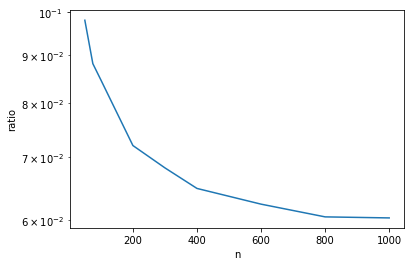

In [140]:
plt.plot(ns_list, bound_our_list / bound_yan_list)
plt.xlabel('n')
plt.ylabel('ratio')
plt.yscale('log')

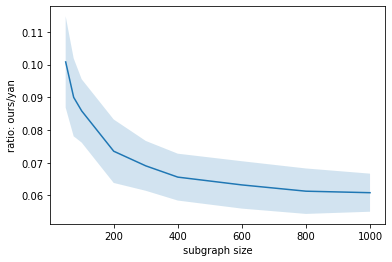

In [148]:
plt.plot(ns_list, ratio_list)
# plt.fill_between(ns_list, np.quantile(ratio_mat, 0.9, axis = 1), np.quantile(ratio_mat, 0.1, axis = 1), alpha = 0.2)
plt.fill_between(ns_list, ratio_list - np.std(ratio_mat, axis = 1), 
                 ratio_list + np.std(ratio_mat, axis = 1), alpha = 0.2)
plt.xlabel('subgraph size')
plt.ylabel('ratio: ours/yan')
# plt.yscale('log')
plt.savefig("barbell_ratio.pdf", bbox_inches = 'tight')

In [147]:
import pickle
with open('barbell_ns_list' + '_p_bridge_' + str(p_bridge) + 'trial' + str(B) + '.pickle', 'wb') as f:
    pickle.dump([ratio_list, ratio_mat, bound_our_list, bound_our_mat, bound_yan_list, bound_yan_mat,
                bound_shah_list, bound_shah_mat], f)